# Fairness Sandox

### Setup

Please run the code block below to install the necessary packages (if needed).

In [ ]:
%pip install aif360
%pip install fairlearn
%pip install imbalanced-learn
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install scikit-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc

import fairlearn
from fairlearn.metrics import *
from fairlearn.reductions import *
import aif360

import copy, random

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Data

### Dataset Class

In [2]:
class Dataset:
    def __init__(self, short_name = '', path = '', cat_cols = [], num_cols = []):
        self.short_name = short_name
        self.path = path
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.df = pd.read_csv(path, sep = ';')

In [3]:
# collection of datasets is a dictionary where keys = short name, values = Dataset object

datasets = dict()

def add_dataset(dataset):
    if not isinstance(dataset, Dataset):
        raise TypeError("Please enter a valid Dataset object")
    else:
        if dataset.short_name not in datasets.keys():
            datasets[dataset.short_name] = dataset

### Popular Datasets

In [4]:
# example - adding a dataset
path_adult_income = 'Datasets/adult.csv'
cat_cols_adult = ['workclass', 'education','marital-status', 'occupation', 'relationship', 'race',
            'gender', 'native-country','income']
num_cols_adult = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
adult_income = Dataset('adult_income', path_adult_income, cat_cols_adult, num_cols_adult)

add_dataset(adult_income)

In [5]:
cat_cols_por = ['school', 'sex', 'address','famsize','Pstatus','Mjob','Fjob','reason',
       'guardian','schoolsup','famsup','paid', 'activities','nursery','higher', 'internet','romantic']
num_cols_por = ['age', 'Medu', 'Fedu','traveltime','studytime','failures', 'famrel',
       'freetime','goout','Dalc','Walc','health','absences','G1', 'G2', 'G3']

add_dataset(Dataset("student_por", path='Datasets/student-por.csv',
                    cat_cols=cat_cols_por, num_cols=num_cols_por))

### Synthetic Data Generation

#### Helper Functions

In [6]:
# create binary sensitive attribute
def get_sensitive_feat(n, r):
    num_minority = int(r * n)
    num_majority = n - num_minority
    
    minority = np.zeros((num_minority, 1))
    majority = np.ones((num_majority, 1))
    
    sens_feat = np.vstack((minority, majority))
    
    # shuffle so as to ensure randomness
    np.random.shuffle(sens_feat)
    
    return sens_feat

In [7]:
def get_cat_feats(num_cat_feats, cat_feats_levels, n):
    cat_feats = []
    for i in range(num_cat_feats):
        levels = cat_feats_levels[i]
        if levels < 2:
            raise ValueError("Categorical features must have at least 2 classes!")
        vals = np.arange(levels)
        cat = np.random.choice(vals, n, [0.5,0.5]).reshape(n, 1)
        cat_feats.append(cat)
    return np.hstack((cat_feats))

In [18]:
def distribution_plot(outcome_min = [], outcome_maj = [], outcome = [],
                      threshold_min = 0.5, threshold_maj = 0.5,
                      diff_dist = False):
    
    if diff_dist:

        plt.figure(figsize=(17,7))

        plt.subplot(1,2,1)
        plt.hist(outcome_min,label='continuous outcome',bins='auto')
        plt.axvline(threshold_min,color='red',label='threshold')
        plt.xlabel("Continuous Outcome")
        plt.ylabel("Number of Samples")
        plt.title("Minority")

        plt.subplot(1,2,2)
        plt.hist(outcome_maj,label='continuous outcome',bins='auto')
        plt.axvline(threshold_maj,color='red',label='threshold')
        plt.xlabel("Continuous Outcome")
        plt.ylabel("Number of Samples")
        plt.title("Majority")
        plt.show()
        
    else:
        
        plt.figure(figsize=(17,7))
        plt.subplot(1,2,1)
        plt.hist(outcome,label='continuous outcome',bins='auto')
        plt.axvline(threshold_min,color='red',label='threshold')
        plt.xlabel("Continuous Outcome")
        plt.ylabel("Number of Samples")
        plt.title("Distribution of Outcomes")
        plt.show()

In [25]:
def get_attribute_names(df, num_numerical_cols, num_cat_cols):
    col_names = []
    for i in range(num_numerical_cols):
        col_names.append('num' + str(i))
    for i in range(num_cat_cols):
        col_names.append('cat' + str(i))
    col_names.append('sens_feat')
    col_names.append('outcome')
    
    return col_names

In [37]:
# flip labels with probability eta
def flip_labels(df_synthetic, label_noise):
    labels = df_synthetic['outcome']
    
    for i in range(len(labels)):
        if random.uniform(0,1) <= label_noise:
            labels[i] = 1 if labels[i] == 0 else 0
    df_synthetic['outcome'] = labels
    
    return df_synthetic

#### Main Function

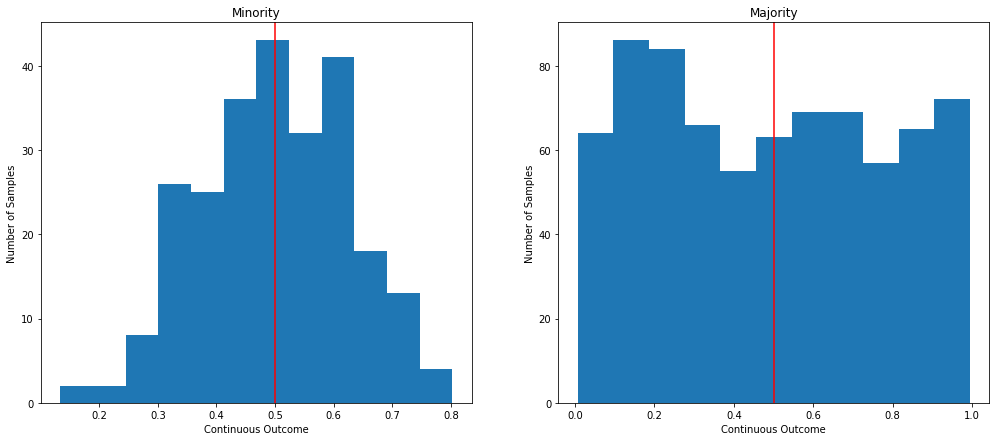

In [44]:
'''
Parameters:

    n is the total number of examples in the dataset
    
    num_numerical_feats is number of numerical features
        each numerical feature is drawn from a
        multivariate normal distribution with mean 0
        
    num_cat_feats is number of categorical features
    
    cat_levels is an array where each element is the number
        of levels for each categorical feature
        len(cat_levels) = num_cat_feats
        
    r is the proportion of examples in the minority group
        (1-r) is proportion of examples in majority group
        
    label_noise is in [0,1]
    
    diff_dist is true if minority and majority have different
        underlying sampling distributions

'''

def get_synthetic_data(n, r, num_numerical_feats, num_cat_feats,
                       cat_levels = [], label_noise = 0, 
                       diff_dist = False):
    
    assert 0 < r < 1, "R must be in [0,1]"
    num_min = int(n*r)
    num_maj = n - num_min
    
    cat_probs = list(np.multiply(np.ones(num_cat_feats),0.5))
    
    # numerical feature params
    means = list(np.zeros(num_numerical_feats))
    cov_matrix = list(np.identity(num_numerical_feats))
    
    # generating the features
    
    num_features_min = np.random.multivariate_normal(means, cov_matrix, num_min)
    num_features_maj = np.random.multivariate_normal(means, cov_matrix, num_maj)
    num_features = np.concatenate((num_features_min, num_features_maj))
        
    # binary sensitive attribute, 0: minority, 1: majority
    sens_feat = get_sensitive_feat(r=r, n=n) 
    
    assert len(cat_levels) == num_cat_feats, \
    "Each categorical feature must have a specification for its number of levels"
    cat_feats = get_cat_feats(num_cat_feats, cat_levels, n)
    
    # generating outcomes (continuous and binary)
    if diff_dist:
        # causal effect params
        effect_param_min = [0.5, -0.2, 0.1] 
        effect_param_maj = [-0.7, 0.5, 1.5]
        outcome_continuous_min = 1/(1+np.exp(-np.matmul(num_features_min,effect_param_min))) # logit model + no added noise
        outcome_continuous_maj = 1/(1+np.exp(-np.matmul(num_features_maj,effect_param_maj)))
        outcome_binary_min = np.where(outcome_continuous_min >= 0.5, 1, 0) # logistic decision boundary
        outcome_binary_maj = np.where(outcome_continuous_maj >= 0.5, 1, 0)
        outcome_binary = np.hstack((outcome_binary_min, outcome_binary_maj)).reshape(n,1)
        distribution_plot(outcome_continuous_min, outcome_continuous_maj, diff_dist=True)
    else:
        effect_param = [0.5, -0.2, 0.1] 
        outcome_continuous = 1/(1+np.exp(-np.matmul(num_features,effect_param))) # logit model + no added noise
        outcome_binary = np.where(outcome_continuous >= 0.5, 1, 0).reshape(n,1) # logistic decision boundary
        distribution_plot(outcome=outcome_continuous, diff_dist=False)

    
    temp_data = np.hstack((num_features, cat_feats, sens_feat, outcome_binary))
    np.random.shuffle(temp_data) # randomly shuffle the data
    
    df_synthetic = pd.DataFrame(temp_data)
    df_synthetic.columns = get_attribute_names(df_synthetic, num_numerical_feats, num_cat_feats)
    
    assert 0 <= label_noise < 1, "Label noise must be in [0, 1)"
    if label_noise != 0:
        df_synthetic = flip_labels(df_synthetic, label_noise)
    
    return df_synthetic

# example usage
df_test = get_synthetic_data(1000, 0.25, 3, 2, [2,3], diff_dist=True, label_noise = 0.1)

# EDA

Feel free to use any/all of the following EDA functions and/or add your own!

In [9]:
# take a peek at the first few data points
df_por = datasets['student_por'].df
df_por.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [7]:
def plot_counts(df, attr):
    if attr in df.columns:
        df[attr].value_counts(normalize=True).plot.barh()
    else:
        print("Error! Please enter a valid feature.")

# example
# plot_counts(df_por, 'sex')

In [8]:
def group_by_plot(df, attr1, attr2):
    for val in list(df[attr1].unique()):
        print(val)
        temp = df[df[attr1] == val]
        sns.displot(temp[attr2])

# example
# group_by_plot(df_por, 'sex', 'G3')

In [9]:
# add support for sns.pairplot, plt.scatter, sns.heatmap

# Preparation

### Problem Formulation

In [10]:
def threshold(df, g_1=0.3, g_2=0.3, g_3=0.4, threshold=11):
    """
    Added "pass/fail" to make problem binary classification
    """
    assert g_1 + g_2 + g_3 == 1, "The sum of the percentages should be 1"
    assert 0 < threshold < 20, "Threshold needs to be between 0 and 20"
    df['pass'] = df.apply(lambda row: 1
                                 if g_1*row['G1'] + g_2*row['G2'] + g_3*row['G3'] >= threshold
                                 else 0, axis=1)
threshold(df_por, threshold=14)
# df_por['pass'].value_counts()

We will now ask you to identify potential sensitive/protected attributes. Run the chunk below to see the different features in the dataset.

In [11]:
# for reference
print(datasets['student_por'].cat_cols)
print(datasets['student_por'].num_cols)

['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


In [12]:
sens_attrs = [df_por['sex'], df_por['address']]

### Data Preprocessing

In [13]:
# format data
X = df_por.iloc[:, :-2].values
y = df_por.iloc[:, -1].values

In [14]:
# OHE categorical features (prompt for user's choice here?)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# get indices of categorical columns
def get_cat_cols(dataset):
    df = dataset.df
    res = []
    for col in dataset.cat_cols:
        res.append(df.columns.get_loc(col))
    return res

cat_cols = get_cat_cols(datasets['student_por'])
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [15]:
X_true = X
y_true = df_por['pass']
#X_bias = copy.deepcopy(X_true)
#y_bias = copy.deepcopy(y_true)

# Bias Injection

### Class Distribution Visualization

In [16]:
#df_por.shape
df_por['address'].value_counts()

U    452
R    197
Name: address, dtype: int64

<AxesSubplot:>

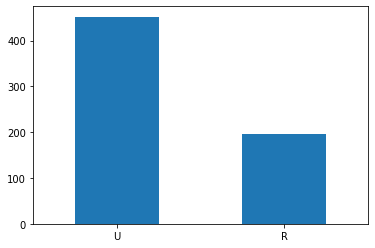

In [17]:
count = pd.value_counts(df_por['address'], sort = True)
count.plot(kind = 'bar', rot = 0)

### Bias Selection

In [18]:
# TODO - add different biases (over/under sampling, omitted variable, etc)

### Bias Injection

In [19]:
# separate based on protected attribute
sens_values = sens_attrs[1].unique()

# TODO - add prompt for user to specify which value is favored and which is unfavored

df_favored = df_por[df_por['address'] == 'U']
df_unfavored = df_por[df_por['address'] == 'R']

### Under-Sampling Process

In [20]:
# under-sampling process
df_undersampled = df_unfavored.sample(n=190, random_state=42)

#print(df_favored.shape, df_unfavored.shape, df_undersampled.shape)

# combine undersampled and original favored class to create dataset
df_concat = pd.concat([df_favored,df_undersampled])
df_concat.shape

# for fairness measures later
df_sens = df_concat['address']

# format data
X_bias = df_concat.iloc[:, :-2].values
#print(X_undersampled.shape)
y_bias = df_concat.iloc[:, -1].values

# OHE
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
X_bias_true = np.array(ct.fit_transform(X_bias))
y_bias_true = df_concat['pass']

#print(X_true.shape, X_bias_true.shape)
#print(y_true.value_counts(), "\n\n", y_bias_true.value_counts())


### Post-Injection Visualization

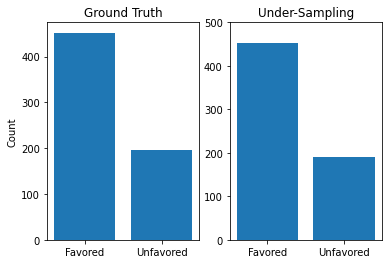

In [21]:
favored = len(df_favored)
true_unfavored = len(df_por[df_por['address'] == 'R'])
bias_unfavored = len(df_undersampled)

x_vals = ['Favored', "Unfavored"]
y_vals_true = [favored, true_unfavored]
y_vals_bias = [favored, bias_unfavored]

plt.subplot(1,2,1)
plt.bar(x_vals, y_vals_true)
plt.title("Ground Truth")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.bar(x_vals, y_vals_bias)
plt.title("Under-Sampling")
plt.ylim([0,500])

plt.show()

# Model

### Model Selection + Training (TODO: modularize)

In [22]:
# modularize and add data struct of different ml techniques

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(min_samples_leaf = 10, max_depth = 4)

classifier_true = classifier.fit(X_true, y_true)
y_pred_truth = classifier_true.predict(X_true)

classifier_bias = classifier.fit(X_bias_true, y_bias_true)
y_pred_bias = classifier_bias.predict(X_bias_true)
y_pred_bias_on_true = classifier_bias.predict(X_true)

### Model Performance (TODO: modularize)

In [19]:
print("Accuracy of Ground Truth Model on Ground Truth Data: ", accuracy_score(y_pred_truth, y_true))
print("Accuracy of Biased Model on Biased Data: ", accuracy_score(y_pred_bias, y_bias_true))
print("Accuracy of Biased Model on Ground Truth Data: ", accuracy_score(y_pred_bias_on_true, y_true))

Accuracy of Ground Truth Model on Ground Truth Data:  0.9845916795069337
Accuracy of Biased Model on Biased Data:  0.9844236760124611
Accuracy of Biased Model on Ground Truth Data:  0.9830508474576272


In [28]:
# Ground Truth Model on Ground Truth Data

gm_true = MetricFrame(accuracy_score, y_true, y_pred_truth, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_true.overall)
print("Group Accuracy : ", gm_true.by_group)

print("\n")

sr_true = MetricFrame(selection_rate, y_true, y_pred_truth, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_true.overall)
print("Group Selection Rate : ", sr_true.by_group)

Overall Accuracy:  0.9845916795069337
Group Accuracy :  address
R    0.979695
U    0.986726
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.2110939907550077
Group Selection Rate :  address
R    0.177665
U    0.225664
Name: selection_rate, dtype: object


In [29]:
# Biased Model on Biased Data

gm_bias = MetricFrame(accuracy_score, y_bias_true, y_pred_bias, sensitive_features = df_sens)
print("Overall Accuracy: ", gm_bias.overall)
print("Group Accuracy : ", gm_bias.by_group)

print("\n")

sr_bias = MetricFrame(selection_rate, y_bias_true, y_pred_bias, sensitive_features = df_sens)
print("Overall Selection Rate: ", sr_bias.overall)
print("Group Selection Rate : ", sr_bias.by_group)

Overall Accuracy:  0.9844236760124611
Group Accuracy :  address
R    0.978947
U    0.986726
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.21495327102803738
Group Selection Rate :  address
R    0.168421
U    0.234513
Name: selection_rate, dtype: object


In [30]:
# Biased Model on Ground Truth Data

gm_bias_on_true = MetricFrame(accuracy_score, y_true,
                           y_pred_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_bias_on_true.overall)
print("Group Accuracy : ", gm_bias_on_true.by_group)

print("\n")

sr_bias_on_true = MetricFrame(selection_rate, y_true,
                              y_pred_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_bias_on_true.overall)
print("Group Selection Rate : ", sr_bias_on_true.by_group)

Overall Accuracy:  0.9830508474576272
Group Accuracy :  address
R    0.974619
U    0.986726
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.21571648690292758
Group Selection Rate :  address
R    0.172589
U    0.234513
Name: selection_rate, dtype: object


In [31]:
print("Ground Truth Model on Ground Truth Data")

print("EOD:", equalized_odds_difference(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))
print("DPD:", demographic_parity_difference(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))

print("EOR:", equalized_odds_ratio(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))
print("DPR:", demographic_parity_ratio(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))

print("\n")

print("Biased Model on Ground Truth Data")

print("EOD:", equalized_odds_difference(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))
print("DPD:", demographic_parity_difference(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))

print("EOR:", equalized_odds_ratio(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))
print("DPR:", demographic_parity_ratio(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))

Ground Truth Model on Ground Truth Data
EOD: 0.047169811320754707
DPD: 0.04799874219486994
EOR: 0.11994219653179189
DPR: 0.7872996914501842


Biased Model on Ground Truth Data
EOD: 0.015425865310954804
DPD: 0.061924441848973555
EOR: 0.35982658959537567
DPR: 0.7359448328704147


# Fairness Intervention

In [24]:
constraint = DemographicParity()
mitigator_true = ExponentiatedGradient(classifier_true, constraint)
mitigator_true.fit(X_true, y_true, sensitive_features = sens_attrs[1])
y_pred_mitigated_true = mitigator_true.predict(X_true)

In [25]:
constraint = DemographicParity()
mitigator_bias = ExponentiatedGradient(classifier_bias, constraint)
mitigator_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
y_pred_mitigated_bias = mitigator_bias.predict(X_bias_true)
y_pred_mitigated_bias_on_true = mitigator_bias.predict(X_true)

# Evaluation

In [36]:
print("Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_pred_mitigated_true, y_true))

print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_pred_mitigated_bias_on_true, y_true))

Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data:  0.9691833590138675
Accuracy of Biased Model + Fairness Intervention on Ground Truth Data:  0.975346687211094


In [37]:
# Ground Truth Model + Fairness Intervention on Ground Truth Data

gm_mitigated = MetricFrame(accuracy_score, y_true, y_pred_mitigated_true, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_mitigated.overall)
print("Group Accuracy : ", gm_mitigated.by_group)

print("\n")

sr_mitigated = MetricFrame(selection_rate, y_true, y_pred_mitigated_true, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_mitigated.overall)
print("Group Selection Rate : ", sr_mitigated.by_group)

Overall Accuracy:  0.9691833590138675
Group Accuracy :  address
R    0.928934
U    0.986726
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.22650231124807396
Group Selection Rate :  address
R    0.228426
U    0.225664
Name: selection_rate, dtype: object


In [38]:
# Biased Model + Fairness Intervention on Ground Truth Data

gm_mitigated_bias_on_true = MetricFrame(accuracy_score, y_true, y_pred_mitigated_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_mitigated_bias_on_true.overall)
print("Group Accuracy : ", gm_mitigated_bias_on_true.by_group)

print("\n")

sr_mitigated_bias_on_true = MetricFrame(selection_rate, y_true, y_pred_mitigated_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_mitigated_bias_on_true.overall)
print("Group Selection Rate : ", sr_mitigated_bias_on_true.by_group)

Overall Accuracy:  0.975346687211094
Group Accuracy :  address
R    0.949239
U    0.986726
Name: accuracy_score, dtype: object


Overall Selection Rate:  0.22033898305084745
Group Selection Rate :  address
R    0.208122
U    0.225664
Name: selection_rate, dtype: object


Hence, we observe an increase in overall and subgroup accuracy, but a decrease in disadvantaged subgroup selection rate

### Bias vs Accuracy vs Fairness Trade-Off

In [64]:
# if verbose, shows "Finished iteration: ... "
# if apply_fairness, uses fairness intervention
def tradeoff_visualization(bias_amts, classifier, X_true, y_true, 
                           df_train, sensitive_feature = "cat",
                           apply_fairness = False, verbose = False):
    
    accuracy_on_true = []
    accuracy_on_biased = []
    accuracy_on_true_mitigated = []
    accuracy_on_biased_mitigated = []

    classifier_true = classifier.fit(X_true, y_true)
    y_pred_truth = classifier_true.predict(X_true)

    df_undersampled = df_unfavored.sample(n=len(df_unfavored), random_state=42)

    for bias in bias_amts:
        # under-sampling process
        if i == 0:
            df_undersampled = df_undersampled.sample(n=len(df_undersampled), random_state=42)
        else:
            df_undersampled = df_undersampled.sample(n=len(df_undersampled)-10, random_state=42)

        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_favored,df_undersampled])
        df_concat.shape
        df_sens = df_concat['address']

        # format data
        X_bias = df_concat.iloc[:, :-2].values
        y_bias = df_concat.iloc[:, -1].values

        # OHE
        ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
        X_bias_true = np.array(ct.fit_transform(X_bias))
        y_bias_true = df_concat['pass']

        classifier_bias = classifier.fit(X_bias_true, y_bias_true)
        
        if apply_fairness:
            constraint = DemographicParity()
            classifier_mitigated_bias = ExponentiatedGradient(classifier_bias, constraint)
            classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
            
            # testing on biased data WITH fairness intervention
            y_pred_mitigated_bias = classifier_mitigated_bias.predict(X_bias_true)
            
            # testing on GT data WITH fairness intervention
            y_pred_mitigated_bias_on_true = classifier_mitigated_bias.predict(X_true)
        
        # testing on biased data withOUT fairness intervention
        y_pred_bias = classifier_bias.predict(X_bias_true)
        
        # testing on GT data withOUT fairness intervention
        y_pred_bias_on_true = classifier_bias.predict(X_true)

        # model performance
        
        if apply_fairness:
            # on biased data
            acc_bias_mitigated = accuracy_score(y_pred=y_pred_mitigated_bias, y_true=y_bias_true)
            accuracy_on_biased_mitigated.append(acc_bias_mitigated)
            # on GT data
            acc_bias_mitigated_on_true = accuracy_score(y_pred=y_pred_mitigated_bias_on_true, y_true=y_true)
            accuracy_on_true_mitigated.append(acc_bias_mitigated_on_true)
        
        # on biased data
        acc_bias = accuracy_score(y_pred=y_pred_bias, y_true=y_bias_true)
        accuracy_on_biased.append(acc_bias)
        # on GT data
        acc_bias_on_true = accuracy_score(y_pred=y_pred_bias_on_true, y_true=y_true)
        accuracy_on_true.append(acc_bias_on_true)
        
        if verbose:
            print("Finished Iteration: ", len(df_concat))

    return bias_amts, dataset_size_true, dataset_size_bias, accuracy_on_biased, accuracy_on_true, eod_on_biased, eod_on_true

In [3]:
def accuracy_visualizations(bias_amts,
                            accuracy_on_biased = [], accuracy_on_true = [],
                            accuracy_on_biased_mitigated = [],
                            accuracy_on_true_mitigated = [], fairness = False):
    
    if fairness:
        plt.figure(figsize=(17,7))

        plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Biased Data')
        plt.xlabel("Amount of Bias (number of minority samples removed)")
        plt.ylabel("Accuracy Score")
        plt.axhline(y=accuracy_score(y_pred_truth, y_true), color = "green", label = "Ground Truth Model Accuracy", alpha = 0.5)
        plt.title("Biased Model Accuracy")
        plt.ylim(0.92, 0.99)
        plt.legend()

        plt.show()
        
    else:
        plt.figure(figsize=(17,7))

        plt.plot(bias_amts, accuracy_on_true, label = 'Ground Truth')
        plt.plot(bias_amts, accuracy_on_biased, label = 'Biased Data')
        plt.xlabel("Amount of Bias (number of minority samples removed)")
        plt.ylabel("Accuracy Score")
        plt.axhline(y=accuracy_score(y_pred_truth, y_true), color = "green", label = "Ground Truth Model Accuracy", alpha = 0.5)
        plt.title("Biased Model Accuracy")
        plt.ylim(0.92, 0.99)
        plt.legend()

        plt.show()

In [5]:
def total_visualizations(bias_amts, accuracy_on_biased, accuracy_on_true,
                        accuracy_on_biased_mitigated, accuracy_on_true_mitigated):
    plt.figure(figsize=(17,7))
    plt.subplot(1,2,1)
    plt.plot(bias_amts, accuracy_on_biased, label = 'Tested On Biased Data + No Fairness Intervention', color = "red")
    plt.plot(bias_amts, accuracy_on_biased_mitigated, label = 'Tested On Biased Data + Fairness Intervention', color = "green")
    plt.plot(bias_amts, accuracy_on_true, label = 'Tested On Ground Truth + No Fairness Intervention', color = "blue")
    plt.plot(bias_amts, accuracy_on_true_mitigated, label = 'Tested On Ground Truth + Fairness Intervention', color = "purple")
    plt.xlabel("Amount of Bias (number of minority samples removed)")
    plt.ylabel("Accuracy Score")
    #plt.axhline(y=accuracy_score(y_pred_truth, y_true), color = "green", label = "Ground Truth Model On Ground Truth Data", alpha = 0.5)
    plt.title("Accuracy of Biased Model (trained on biased data)")
    plt.legend()
    plt.show()